<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/model_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import pickle
import matplotlib.pyplot as plt


import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2.4.1
2.4.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load songs
songs = pd.read_csv('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/data/lana_lyrics_98.csv')
songs.shape

(98, 2)

In [5]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [6]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [7]:
corpus = list(set(text.lower().split('\n')))
corpus[:5]

['',
 "sunsets, small town, i'm out of time",
 "when i'm down on my knees, you're how i pray",
 "so i run like i'm mad to heaven's door",
 'as you do now, my man"']

In [8]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)

# with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


total_words = len(tokenizer.word_index) + 1
print(total_words)

2575


In [9]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[20:30]

[[33, 2, 191, 11, 12, 654, 5],
 [33, 2, 191, 11, 12, 654, 5, 1296],
 [33, 2, 191, 11, 12, 654, 5, 1296, 707],
 [76, 1],
 [76, 1, 29],
 [76, 1, 29, 40],
 [76, 1, 29, 40, 7],
 [76, 1, 29, 40, 7, 94],
 [44, 26],
 [44, 26, 2]]

In [10]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

In [11]:
input_sequences[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1615,  485],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1615,  485,  229]], dtype=int32)

In [12]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors.shape

(17490, 17)

### Building The Model

In [32]:
K.clear_session()

def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

vocab_size = total_words
embed_dim = 50
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.1))
    # Add another LSTM Layer
    model.add(LSTM(100,return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(vocab_size/2, activation='relu'))
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    return model

model = create_model(vocab_size, embed_dim)
model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 50)            128750    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 17, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1287)              129987    
_________________________________________________________________
dense_1 (Dense)              (None, 2575)              3

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')

Epoch 1/100
547/547 [==============================] - 10s 11ms/step - loss: 6.5394 - accuracy: 0.0362
Epoch 2/100
547/547 [==============================] - 6s 11ms/step - loss: 5.9494 - accuracy: 0.0429
Epoch 3/100
547/547 [==============================] - 6s 11ms/step - loss: 5.6886 - accuracy: 0.0479
Epoch 4/100
547/547 [==============================] - 6s 11ms/step - loss: 5.3674 - accuracy: 0.0748
Epoch 5/100
547/547 [==============================] - 6s 12ms/step - loss: 5.1154 - accuracy: 0.0923
Epoch 6/100
547/547 [==============================] - 6s 12ms/step - loss: 4.9292 - accuracy: 0.1093
Epoch 7/100
547/547 [==============================] - 6s 11ms/step - loss: 4.7876 - accuracy: 0.1122
Epoch 8/100
547/547 [==============================] - 6s 11ms/step - loss: 4.5966 - accuracy: 0.1286
Epoch 9/100
547/547 [==============================] - 6s 11ms/step - loss: 4.4844 - accuracy: 0.1351
Epoch 10/100
547/547 [==============================] - 6s 11ms/step - loss: 4.32

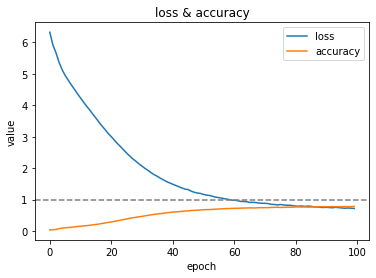

In [34]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='gray', linestyle='--')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [101]:
# def create_model_2(vocab_size, embed_dim):
#     model = Sequential()
#     model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

#     # Add an LSTM Layer
#     model.add(Bidirectional(LSTM(300, return_sequences=False)))
#     # A dropout layer for regularisation
#     model.add(Dropout(0.2))
#     # Add another LSTM Layer
#     # model.add(LSTM(100,return_sequences=False)) 
#     model.add(Dense(vocab_size/2, activation='relu'))
#     # In the last layer, the shape should be equal to the total number of words present in our corpus
#     model.add(Dense(vocab_size, activation='softmax'))
#     return model

# model_2 = create_model_2(vocab_size, embed_dim)
# model_2.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
# print(model_2.summary())

In [102]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# history_2 = model_2.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stopping])

# # Save the weights
# model_2.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word2/ldr_by_word2')

# # summarize history for accuracy
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.axhline(y=1, color='k')
# plt.title('loss & accuracy')
# plt.ylabel('value')
# plt.xlabel('epoch')
# plt.legend()
# plt.show()

#### Recreate the model and load saved weights

In [17]:
# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'rb') as f:
    tokenizer_reload = pickle.load(f)

In [18]:
# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')
model_loaded.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')

In [19]:
def make_lyrics(model, seed_text, next_words, tokenizer=tokenizer_reload):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [109]:
# seed_text = 'take me to'
# temperature = 1
# next_words = 500
# for _ in range(next_words):
#     token_list = tokenizer.texts_to_sequences([seed_text])[0]
#     token_list = pad_sequences([token_list],
#                         maxlen=max_sequence_len-1,padding='pre')

#     predicted_probs = model.predict(token_list, verbose=0)
#     probs = np.exp(predicted_probs[0]/temperature)

#     normalized_probablities = probs / sum(probs)
#     predicted = np.random.choice(range(vocab_size), p=normalized_probablities)
#     output_word = ""
#     for word, index in tokenizer.word_index.items():
#         if index == predicted:
#             output_word = word
#             break
#     seed_text += " " + output_word
# seed_text

In [20]:
predicted_lyrics = make_lyrics(model_loaded, 'you\'re so art deco out on the floor shining like gun metal', 100)
print(predicted_lyrics)

you're so art deco out on the floor shining like gun metal we keep dancin' babe what oh say that about me not good for me to be for you to think that i'm not a soul high what oh what ah yeah yeah yeah we all all say baby you know that you know what you know that you know that you know that you're mine in the bed that you came from blue day i baby it all of you know me in my arms you a top of it a television that's real a girl about me a stairway in my the you tonight it all the on a


In [21]:
predicted_lyrics = make_lyrics(model_loaded, 'country club', 100)
print(predicted_lyrics)

country club man man like a good for me for real for real for real for you to lie to me my little love my love you our love is and our real love on the night of the on the of the of the on the of the for the for the for the my love ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah


Test Loaded model

In [22]:
predicted_lyrics = make_lyrics(model_loaded, 'I can see my baby swinging', 100)
print(predicted_lyrics)

I can see my baby swinging with the architecture long bored of it died for real for real for the to of gin to me my way off all the you but you you know me when i'm so in love ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah


In [78]:
predicted_lyrics = make_lyrics(model_loaded, 'he\'s crazy', 100)
print(predicted_lyrics)

he's crazy y cubano como yo la la la la losers beautiful losers yeah now yes… all the time i feel it comin' in my pad thrills by the time summer's done to do it i had a ball sad girl a lie band by thе quick lunch stand cool as darker and against the docks and shit what life is a lie band to call me with hurting me slowly is a lie band in thе quick lunch stand cool as i'm already coolest it a ball book it's 2 gonna happen wander for a minute in my face is shameless


In [110]:
predicted_lyrics = make_lyrics(model_loaded, 'jesus is my bestest friend', 100)
print(predicted_lyrics)

jesus is my bestest friend for us hard crazy and that's what what what what what what what yeah shatter yeah oh time to eat soft ice cream thing with a stairway for the eyes he stood on the fuckin' youth they love their movies as war alright away you ends my boyfriend's in a band singer and you're my cult leader without you fail the blue dress on day long ask for a song life 'cause hard in the city by the bay gets late like shit you don't need to love you on her father opened so long the fuckin' near friend it


In [207]:
# word_counts_df = pd.DataFrame.from_dict(dict(tokenizer.word_counts), orient='index')
# word_counts_df.reset_index(inplace=True)
# word_counts_df.columns = ['word', 'count']

In [17]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS as w_stop
len(w_stop)

190

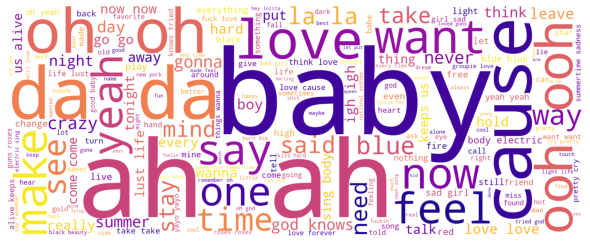

In [26]:
stopwords = set(w_stop)
extra = ['got', 'know']
for word in extra:
    stopwords.add(word)

wordcloud = WordCloud(width = 2000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, 
                colormap='plasma').generate(text)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [69]:
np.random.choice(text.split('\n'))

''